# Session 1: Escaping GridWorld with Simple RL Agents

## Colab Setup

In [1]:
#uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls

## Imports

In [2]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
#cross check with our solutions once you finish
# from solutions.agents import GridworldAgent
from solutions.environments import Gridworld

## What is Reinforcement Learning

In [23]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/SvXXpmXedHE" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

In [24]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/Ru5xQPZPRUI" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

## How Useful is Reinforcement Learning

Deep reinforcement learning has been successful (better than or equal to supervised learning) in:
* Beating professional [Go players](https://deepmind.com/research/alphago/), [Flappy Bird](https://www.youtube.com/watch?v=hri7ir5qhj0) and, to some extent [DotA players](https://youtu.be/UZHTNBMAfAA?t=2m40s).
* Reduce data center power usage and [save 40% of electricity bill](https://deepmind.com/blog/deepmind-ai-reduces-google-data-centre-cooling-bill-40/)
* Neural architecture search for better algorithms aka [AutoML](https://cloud.google.com/automl/)
* Control tasks for robotics like [this](https://www.youtube.com/watch?v=W_gxLKSsSIE) and [this](https://www.youtube.com/watch?v=gn4nRCC9TwQ)
* [Self-driving cars](https://www.youtube.com/watch?v=opsmd5yuBF0)
* [Ads bidding](http://wnzhang.net/papers/rlb.pdf)

And most likely being tried for:
* [Algorithmic trading](http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/)
* [Supply chain management](https://www.youtube.com/watch?v=gQa6iWGcGWY)
* Drug discovery
* Security
* Recommendation engines

## Why is Reinforcement Learning Different

Level of workflow automation in classes of machine learning algorithm:
* Supervised Learning
$$\text{Raw Data (X,y)} \Rightarrow \text{Labeled Data} \rightarrow \text{Model} \rightarrow \text{Predicted Labels} \Rightarrow \text{Actions}$$

* Unsupervised Learning
$$\text{Raw Data (X)} \rightarrow \text{Model} \rightarrow \text{Predicted Clusters} \Rightarrow \text{Labled Clusters} \Rightarrow \text{Actions}$$

* Reinforcement Learning
$$\text{Raw Data} \Rightarrow \text{RL Scheme (S,A,R,S',A')} \rightarrow \text{Model} \rightarrow \text{Action}$$


where $\Rightarrow$ denotes transformations that require humans and $\rightarrow$ denotes those that do not.

## Fill in The Code

In [5]:
import numpy as np
from collections import defaultdict
import sys

"""
Coding assignment order:
1. select_action
2. get_v
"""

class GridworldAgent:
    def __init__(self, env, policy, gamma = 0.9, 
                 start_epsilon = 0.9, end_epsilon = 0.1, epsilon_decay = 0.9):
        self.env = env
        self.n_action = len(self.env.action_space)
        self.policy = policy
        self.gamma = gamma
        self.v = dict.fromkeys(self.env.state_space,0)
        self.n_v = dict.fromkeys(self.env.state_space,0)
        self.q = defaultdict(lambda: np.zeros(self.n_action))
        self.n_q = defaultdict(lambda: np.zeros(self.n_action))
        self.start_epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.epsilon_decay = epsilon_decay
    def get_epsilon(self,n_episode):
        epsilon = max(self.start_epsilon * (self.epsilon_decay**n_episode),self.end_epsilon)
        return(epsilon)
    def get_v(self,start_state,epsilon = 0.):
        episode = self.run_episode(start_state,epsilon)
        """
        Write the code to calculate the state value function of a state 
        given a deterministic policy.
        """
        episode = self.run_episode(start_state,epsilon)
        v=0
        return(v)
    def get_q(self, start_state, first_action, epsilon=0.):
        episode = self.run_episode(start_state,epsilon,first_action)
        q = np.sum([episode[i][2] * self.gamma**i for i in range(len(episode))])
        return(q)
    def select_action(self,state,epsilon):
        """
        Currently the agent only selects a random action.
        Write the code to make the agent perform 
        according to an epsilon-greedy policy.
        """
        probs = np.ones(self.n_action) * (1 / self.n_action)
        action = np.random.choice(np.arange(self.n_action),p=probs)
        return(action)
    def print_policy(self):
        for i in range(self.env.sz[0]):
            print('\n----------')
            for j in range(self.env.sz[1]):
                p=self.policy[(i,j)]
                out = self.env.action_text[p]
                print(f'{out} |',end='')
    def print_v(self, decimal = 1):
        for i in range(self.env.sz[0]):
            print('\n---------------')
            for j in range(self.env.sz[1]):
                out=np.round(self.v[(i,j)],decimal)
                print(f'{out} |',end='')
    def run_episode(self, start, epsilon, first_action = None):
        result = []
        state = self.env.reset(start)
        #dictate first action to iterate q
        if first_action is not None:
            action = first_action
            next_state,reward,done = self.env.step(action)
            result.append((state,action,reward,next_state,done))
            state = next_state
            if done: return(result)
        while True:
            action = self.select_action(state,epsilon)
            next_state,reward,done = self.env.step(action)
            result.append((state,action,reward,next_state,done))
            state = next_state
            if done: break
        return(result)
    def update_policy_q(self):
        for state in self.env.state_space:
            self.policy[state] = np.argmax(self.q[state])
    def mc_predict_v(self,n_episode=10000,first_visit=True):
        for t in range(n_episode):
            traversed = []
            e = self.get_epsilon(t)
            transitions = self.run_episode(self.env.start,e)
            states,actions,rewards,next_states,dones = zip(*transitions)
            for i in range(len(transitions)):
                if first_visit and (states[i] not in traversed):
                    traversed.append(states[i])
                    self.n_v[states[i]]+=1
                    discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
                    self.v[states[i]]+= sum(rewards[i:]*discounts[:-(1+i)])
        for state in self.env.state_space:
            if state != self.env.goal:
                self.v[state] = self.v[state] / self.n_v[state]
            else:
                self.v[state] = 0
    
    def mc_predict_q(self,n_episode=10000,first_visit=True):
        for t in range(n_episode):
            traversed = []
            e = self.get_epsilon(t)
            transitions = self.run_episode(self.env.start,e)
            states,actions,rewards,next_states,dones = zip(*transitions)
            for i in range(len(transitions)):
                if first_visit and ((states[i],actions[i]) not in traversed):
                    traversed.append((states[i],actions[i]))
                    self.n_q[states[i]][actions[i]]+=1
                    discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
                    self.q[states[i]][actions[i]]+= sum(rewards[i:]*discounts[:-(1+i)])
                elif not first_visit:
                    self.n_q[states[i]][actions[i]]+=1
                    discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
                    self.q[states[i]][actions[i]]+= sum(rewards[i:]*discounts[:-(1+i)])

        #print(self.q,self.n_q)
        for state in self.env.state_space:
            for action in range(self.n_action):
                if state != self.env.goal:
                    self.q[state][action] = self.q[state][action] / self.n_q[state][action]
                else:
                    self.q[state][action] = 0
        
    def mc_control_q(self,n_episode=10000,first_visit=True):
        self.mc_predict_q(n_episode,first_visit)
        self.update_policy_q()
        
    def mc_control_glie(self,n_episode=10000,first_visit=True,lr=0.):
        for t in range(n_episode):
            traversed = []
            e = self.get_epsilon(t)
            transitions = self.run_episode(self.env.start,e)
            states,actions,rewards,next_states,dones = zip(*transitions)
            for i in range(len(transitions)):
                if first_visit and ((states[i],actions[i]) not in traversed):
                    traversed.append((states[i],actions[i]))
                    self.n_q[states[i]][actions[i]]+=1
                    discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
                    g = sum(rewards[i:]*discounts[:-(1+i)])
                    if lr > 0:
                        a = lr
                    else:
                        a = (1/self.n_q[states[i]][actions[i]])
                    self.q[states[i]][actions[i]]+= a*(g - self.q[states[i]][actions[i]])
                    self.update_policy_q()

## Reinforcement Learning Framework

Reinforcement learning formulates interaction between an **agent** and its **environment** as **Markov decision processes**. For a given **state**, an agent takes an **action** based on the current **state**. In response to that action at that state, the agent will then get some **reward** from the environment, and that state changes to the next one.

$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$

where $t$ is the last time step and $S_t$ is the **terminal state** meaning an **episode** of the interactions ended. RL problems that have an end are called **episodic tasks** and those that do not are called **continuous tasks**.

![RL Framework](img/rl_framework.png)
Source: [Sutton and Barto](https://cdn.preterhuman.net/texts/science_and_technology/artificial_intelligence/Reinforcement%20Learning%20%20An%20Introduction%20-%20Richard%20S.%20Sutton%20,%20Andrew%20G.%20Barto.pdf)

### Example

* Walking robots
    * Environment: sidewalks
    * Agent: a robot
    * States: positions, velocities and accelerations of body parts
    * Actions: move arms, legs, various joints in the body
    * Rewards: fall or not
    * Episodes: seconds, miliseconds until fall
* Ads bidding
    * Environment: Google Adwords
    * Agent: an ecommerce company
    * States: campaign impressions, clicks, purchases
    * Actions: adjust bid prices and budget
    * Rewards: conversion rates, cost of new customer acquisitions
    * Episodes: daily or hourly until campaign ends
* Retail stock trading
    * Environment: the stock market
    * Agent: a retail investor who cannot influence market prices
    * States: market prices, volumes, and other indicators
    * Actions: buy, hold, sell
    * Rewards: returns, returns adjusted by volatility, and so on
    * Episodes: daily, hourly, every second until we are extremely rich or broke
    
**Concept Assigment** Come up with one or more scenarios that you think could be framed as a reinforcement learning problem and list their elements like the example above. Some candidates are:
* [AlphaGo](https://deepmind.com/research/alphago/)
* [OpenAI Five Dota Bots](https://openai.com/five/)
* [Pancake-flipping Robots](https://www.youtube.com/watch?v=W_gxLKSsSIE&list=PL5nBAYUyJTrM48dViibyi68urttMlUv7e)

## Markov Property - One-step Dynamics

One of the most fundamental assumptions of many reinforcement learning algorithms is that the interactions of the world has **Markov property**. That is, the transitions between states only depend on the current state and action, and not the history of transitions formulated as:

$$P(s_{t+1},r_{t+1}|s_t,a_t,r_t,s_{t-1},a_{t-1},...,r_1,s_0,a_0) = P(s_{t+1},r_{t+1}|s_t,a_t)$$

This can be seen as unrealistic as we intuitively use cues from a history of transitions to choose our actions in real life but as you will learn its simplicity has merits in terms of reduced complexity in real-world applications and we can incorporate long-term goals into reinforcement learning. In fact, long-term goals are one of the most important research area in reinforcement learning today.

![RL Framework](img/mdp_weather.png)

**Quick Notation** $P(x|y)$ means the probability of $x$ occuring given $y$. For instance, $P(cold|cough)$ is probability that you have a cold, given that you are coughing.



## Environment - Gridworld

### What The Gridworld Looks Like

We are going to work on an equivalent of a poor man's version of [Unity's Gridworld](http://awjuliani.github.io/GridGL/).

* `F` - Free tiles; agent can move to
* `T` - Traps; agent recieves some penalty
* `G` - The Goal, episode ends once reached

In [6]:
env = Gridworld()
env.print_physical(visible_only=False)


------------------------------------
['F', 'x'] |['F', 'x'] |['F', 'x'] |
------------------------------------
['F', 'x'] |['T', 'x'] |['G', 'x'] |
------------------------------------
['F', 'o'] |['F', 'x'] |['F', 'x'] |

### States

In [7]:
env.state_space

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

### Actions

In [8]:
env.action_space, env.action_text

(array([0, 1, 2, 3]), array(['U', 'L', 'D', 'R'], dtype='<U1'))

### Rewards

In [9]:
env.print_reward()


----------
0 |0 |0 |
----------
0 |-5 |5 |
----------
0 |0 |0 |

In [10]:
env.move_reward

-1

### What The Agent Usually Sees

In [11]:
env.print_physical(visible_only=True)


------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['F', 'o'] |['NA', 'NA'] |['NA', 'NA'] |

In [12]:
#go down
action = np.argwhere(env.action_text=='U')
print(env.step(action))
#then right
action = np.argwhere(env.action_text=='R')
print(env.step(action))
env.print_physical(visible_only=True)

((1, 0), -1, False, 'info')
((1, 1), -6, False, 'info')

------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['F', 'x'] |['T', 'o'] |['NA', 'NA'] |
------------------------------------
['F', 'x'] |['NA', 'NA'] |['NA', 'NA'] |

### Deterministic Environment vs Stochastic Environment

In [13]:
env = Gridworld(wind_p=0.5)
#go down
action = np.argwhere(env.action_text=='U')
print(env.step(action))
#then right
action = np.argwhere(env.action_text=='R')
print(env.step(action))
env.print_physical(visible_only=True)

((1, 0), -1, False, 'info')
((1, 2), 4, True, 'info')

------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['F', 'x'] |['NA', 'NA'] |['G', 'o'] |
------------------------------------
['F', 'x'] |['NA', 'NA'] |['NA', 'NA'] |

## Agent

### Deterministic Policy

$\pi(s) \in \mathcal{A}(s)$ for all $s \in \mathcal{S}$

In [14]:
#deterministic env
env = Gridworld(wind_p=0.)
#deterministic policy
policy_a = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 2,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
policy_b = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 2,
          (1, 0): 0,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 3,
          (2, 2): 0}

#peek
print('Reward Grid')
env.print_reward()
print('\n')
a = GridworldAgent(env,policy_a)
print('Policy A: Reach Goal ASAP')
a.print_policy()
print('\n')
print('Policy B: Avoid Trap')
a.policy = policy_b
a.print_policy()

Reward Grid

----------
0 |0 |0 |
----------
0 |-5 |5 |
----------
0 |0 |0 |

Policy A: Reach Goal ASAP

----------
R |R |D |
----------
R |R |U |
----------
R |U |U |

Policy B: Avoid Trap

----------
R |R |D |
----------
U |R |U |
----------
R |R |U |

### Stochastic Policy - Epsilon Greedy

$\pi(a|s) = \mathbb{P}(A_t=a|S_t=s)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}(s)$

**Coding Assignment** Implement epsilon greedy in the `select_action` function of `agent.py`.

Hint: Pseudo-code looks like this
```
r = random number between 0 and 1
if r > epsilon:
    perform best action
else:
    perform random action
```

Preferred action for (0, 0) is 3
At epsilon 0.5, we get:


<a list of 10 Patch objects>

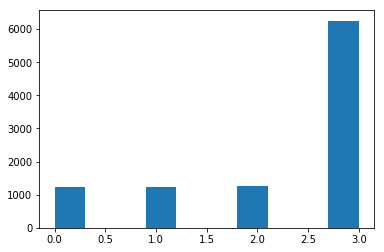

In [15]:
state = (0,0)
print(f'Preferred action for {state} is {a.policy[state]}')
print('At epsilon 0.5, we get:')
actions = np.array([a.select_action(state,epsilon=0.5) for i in range(10000)])
plt.hist(actions)[2]

In [16]:
#epsilon decaying 
a = GridworldAgent(env,policy_a,start_epsilon=0.9,end_epsilon=0.1,epsilon_decay=0.9)

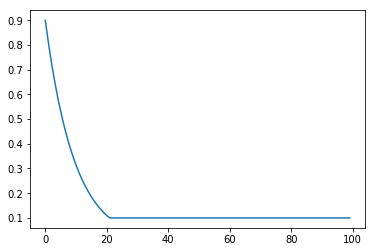

In [17]:
eps = np.array([a.get_epsilon(i) for i in range(100)])
plt.plot(eps)

### State Value

$v_\pi(s) = \sum_{a \in \mathcal{A}(s)}\pi(a|s)\sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma v_\pi(s'))$

In [18]:
#deterministic env
env = Gridworld(wind_p=0.)
policy = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 2,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
a = GridworldAgent(env,policy = policy, gamma = 1)
print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

Reward Grid

----------
0 |0 |0 |
----------
0 |-5 |5 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |D |
----------
R |R |U |
----------
R |U |U |

**Coding Assigment** Implement `get_v` to find out the state value of each state.

Hint: Pseudo-code looks like this

```
Run through the gridworld, starting at `start_state` and save transitions to `episode`
`episode` contains n transitions and each looks like this (state,action,reward,next_state,done)

value = 0
for i in 0 to n:
    value += reward[i] * (gamma**i)
return(value)
```

In [19]:
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()


---------------
2 |3 |4 |
---------------
-2 |4 |3 |
---------------
-3 |-2 |4 |

In [20]:
a.gamma = 0.5
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()


---------------
-0.5 |1.0 |4.0 |
---------------
-4.0 |4.0 |1.0 |
---------------
-3.0 |-4.0 |4.0 |

**Concept assigment** What are the best discount factor $\gamma$ for each of the following environments?
* [CartPole OpenAI](https://github.com/openai/gym/wiki/CartPole-v0) - An agent is a cart trying to balance a pole by going left or right. It gets +1 for each step the pole stays on and +0 when the pole falls over.
* [CartPole Alternative](http://incompleteideas.net/book/the-book-2nd.html) - An agent is a cart trying to balance a pole by going left or right. It gets -1 if the pole falls over and +0 otherwise.
* [Banana Collector](https://www.youtube.com/watch?v=heVMs3t9qSk) - An agent is a robot who collects bananas in a room. It gets +1 for yellow bananas and -1 for blue bananas. The time limit is 300 steps.

### (State-)Action Value

$q_\pi(s,a) = \sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma\sum_{a' \in \mathcal{A}(s')} \pi(a'|s') q_\pi(s',a'))$

In [21]:
print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

a.gamma=1
for state in env.state_space:
    for action in env.action_space:
        a.q[state][action] = a.get_q(state,action,epsilon=0.)

print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])

Reward Grid

----------
0 |0 |0 |
----------
0 |-5 |5 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |D |
----------
R |R |U |
----------
R |U |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [ 1.  1. -3.  2.]
(0, 1) [ 2.  1. -2.  3.]
(0, 2) [3. 2. 4. 3.]
(1, 0) [ 1. -3. -4. -2.]
(1, 1) [ 2. -3. -3.  4.]
(1, 2) [ 3. -2.  3. -1.]
(2, 0) [-3. -4. -4. -3.]
(2, 1) [-2. -4. -3.  3.]
(2, 2) [ 4. -3.  3.  3.]


### Comparing Policies

When comparing two policies a and b:

$\pi_a > \pi_b$ if and only if $v_{\pi_a}(s) > v_{\pi_b}(s)$ for all $s \in \mathcal{S}$

An optimal policy $\pi^*$ is defined as:

$\pi^* > \pi$ for all $\pi$

We can also find an optimal policy from action value function as choosing the action with the highest q-value out of any action in that state:

$\pi^*(s) = argmax_{a \in \mathcal{A}}q^*(s,a)$

In [22]:
#deterministic env
env = Gridworld(wind_p=0.)
#deterministic policy
policy_a = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 2,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
policy_b = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 2,
          (1, 0): 0,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 3,
          (2, 2): 0}

a = GridworldAgent(env,policy_a)
print('Policy A: Reach Goal ASAP')
a.print_policy()
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()
print('\n')
print('Policy B: Avoid Trap')
a.policy = policy_b
a.print_policy()
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()

Policy A: Reach Goal ASAP

----------
R |R |D |
----------
R |R |U |
----------
R |U |U |
---------------
1.3 |2.6 |4.0 |
---------------
-2.4 |4.0 |2.6 |
---------------
-3.2 |-2.4 |4.0 |

Policy B: Avoid Trap

----------
R |R |D |
----------
U |R |U |
----------
R |R |U |
---------------
1.3 |2.6 |4.0 |
---------------
0.2 |4.0 |2.6 |
---------------
1.3 |2.6 |4.0 |

## Words of Caution

A few reasons [Deep Reinforcement Learning Doesn't Work Yet](https://www.alexirpan.com/2018/02/14/rl-hard.html):
* It still takes too much time to learn simple things; for instance, one of the previous state-of-the-art Rainbow model takes over 80 hours to learn to play Atari games at human level. Even a child would only need a few hours on their phone.
* Supervised learning works so well.
* Instead of labels, you decide on a reward to motivate the models and it is a tricky business; for example, how would give rewards to an humanoid robot agent for it to learn how to walk?
* There are so many hyperparameters to take care of.
* A lot of times it is [just random search](https://arxiv.org/abs/1803.07055).

![Foundational Flaw](img/foundational_flaw.PNG)

Source: [Reinforcement learning’s foundational flaw](https://thegradient.pub/why-rl-is-flawed/)

## Challenges

* Read up on Bellman's equations and find out where they hid in our workshop today.
* What are you ideas about how we can find the policy policy?
* Play around with Gridworld. Tweak these variables and see what happens:
    * Expand the grid and/or add some more traps
    * Wing probability
    * Move rewards
    * Discount factor
    * Epsilon and how to decay it (or not)